In [ ]:
%matplotlib notebook

## Model loader class

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle

from helper_functions import *

data = pickle.load(open('data3_4.p', 'rb'))
test_images, test_labels = pickle.load(open('x_test.p','rb')), pickle.load(open('y_test.p','rb'))
        
class Loader():
    def __init__(self, model_path='/tmp/model-final.ckpt'):
        self.model_path = model_path
        
        tf.reset_default_graph()

        global_step = tf.Variable(0, name='global_step', trainable=False)

        # Initialize input and target tensors
        with tf.name_scope('input'):
            x = tf.placeholder(tf.float32, shape=[None, 784], name='x-input')
            y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')

        # Initialize weight and bias tensors
        with tf.name_scope('convolutional_layer_1'):
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])

        with tf.name_scope('input_reshape'):
            x_image = tf.reshape(x, [-1,28,28,1])
            tf.summary.image('input', x_image, 10)

        with tf.name_scope('convolutional_layer1'):
            h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

        with tf.name_scope('pooling_layer_1'):
            h_pool1 = max_pool_2x2(h_conv1)

        with tf.name_scope('convolutional_layer_2'):
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])        
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

        with tf.name_scope('pooling_layer_2'):
            h_pool2 = max_pool_2x2(h_conv2)

        with tf.name_scope('fully_connected_layer_1'):
            W_fc1 = weight_variable([7 * 7 * 64, 512])
            b_fc1 = bias_variable([512])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        with tf.name_scope('dropout'):
            keep_prob = tf.placeholder(tf.float32, name='keep_prob')
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)                    

        with tf.name_scope('fully_connected_layer_2'):
            W_fc2 = weight_variable([512, 10])
            b_fc2 = bias_variable([10])
            y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

        with tf.name_scope('cross_entropy'):
            diff = tf.nn.softmax_cross_entropy_with_logits(y_conv, y_)
            with tf.name_scope('total'):
                cross_entropy = tf.reduce_mean(diff)

        with tf.name_scope('train'):
            train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

        with tf.name_scope('accuracy'):
            with tf.name_scope('correct_prediction'):
                correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
            with tf.name_scope('accuracy'):
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        with tf.Session() as sess:
            init_op = tf.global_variables_initializer()
            saver = tf.train.Saver()
            # Initialize variables
            sess.run(init_op)
            # Restore model weights from previously saved model
            saver.restore(sess, self.model_path)
            print("Model restored from file: %s" % self.model_path)
            self.y_conv, self.x, self.y_, self.keep_prob = y_conv, x, y_, keep_prob
            self.output = sess.run([y_conv],feed_dict={x: test_images[:5].reshape(-1,784), y_: test_labels[:5], keep_prob:1.0})
            print(self.output)
            
    def classify(self,images,labels,imshow=False):
        if labels.shape[0] == 10:
            labels = [labels]            
        
        with tf.Session() as sess:
            init_op = tf.global_variables_initializer()
            saver = tf.train.Saver()
            # Initialize variables
            sess.run(init_op)
            # Restore model weights from previously saved model
            saver.restore(sess, self.model_path)
            print("Model restored from file: %s" % self.model_path)
            self.output = sess.run([self.y_conv],feed_dict={self.x: images, self.y_: labels, self.keep_prob:1.0})
            if imshow:
                for ind, image in enumerate(images):                    
                    f, ax = plt.subplots()
                    ax.set_title('PREDICTION: ' + str(np.argmax(self.output[0][ind])) +' CORRECT: ' + str(np.argmax(labels[ind])))
                    ax.imshow(image.reshape(28,28), cmap='gray')
                    plt.axis('off')
                    plt.show()
            

In [23]:
loader = Loader()

Model restored from file: /tmp/model-final.ckpt
[array([[   7.83362913,  -12.84924412,    1.59282863,   -0.31561297,
         -11.39520931,   -1.20100546,    3.48759437,   -7.18297338,
          14.84652996,    1.02751446],
       [   8.13209152,  -28.98106956,   -7.50319767,   13.69855785,
         -32.49728012,   53.97368622,  136.34501648,  -59.30072784,
          36.29725266,  -18.43057251],
       [  44.62570953,  -26.28982925,   15.23305893,   24.01831055,
         -26.67537689,    0.43133911,  -11.78556347,  -31.41679573,
          22.91046906,   -8.49624348],
       [ -23.06151581,   -0.4432587 ,   -6.15900135,   -7.4946332 ,
          31.59944153,   -7.90786791,   33.15507889,   -2.74865341,
         -18.51459885,  -14.09843922],
       [   6.56081629,  -24.93846893,    7.61520338,   -0.45531392,
         -31.24323654,  -16.28620911,    5.59246206,  -14.54810905,
          69.995224  ,  -14.62962151]], dtype=float32)]


Model restored from file: /tmp/model-final.ckpt


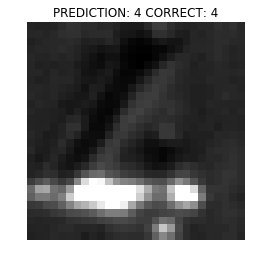

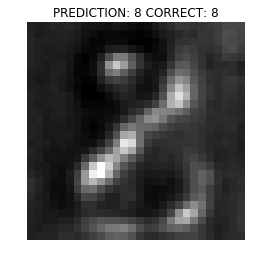

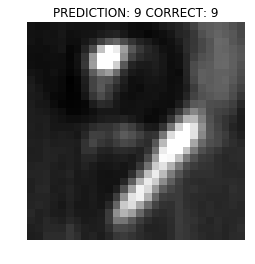

In [25]:
loader.classify(test_images[15:18].reshape(-1,784),test_labels[15:18],imshow=True)